In [71]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import string
import re
import os
from zipfile import ZipFile
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

In [72]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [73]:
file_name = 'lyrics.zip'
dir_path = ''

with ZipFile(file_name, 'r') as zip:
    zip.extractall(path=dir_path)
    print('Done')

text = ''

# os.listdir(dir_path) returns a list of filenames in the directory
for filename in os.listdir('./lyrics'):
    # Check if the file is a .txt file
    if filename.endswith('.txt'):
        with open(os.path.join('./lyrics', filename), 'r', encoding='utf-8') as f:
            text += f.read().lower()

Done


In [74]:
# hyperparameters
n_features = 348
n_heads = 6
n_layers = 6
dropout = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
block_size = 256 # what is the maximum context length for predictions?
batch_size = 64 # how many independent sequences will we process in parallel?
learning_rate = 3e-4
eval_interval = 500
max_iters = 18000
eval_iters = 200
temperature = 1.0

In [75]:
print(len(text))

6731387


In [76]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
vocab_size

126

In [77]:
print(chars[:100])
print(''.join(chars))

['\t', '\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '>', '?', '@', '[', ']', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '¡', '¢', '¨', '©', 'ª', '«', '¬', '\xad', '±', '²', '³', '´', '¶', '»', '¼', '¿', 'ß', 'à', 'á', 'â', 'ã', 'ä', 'å', 'ç', 'è', 'é', 'ê', 'ë', 'ì', 'í', 'ð', 'ñ', 'ò']
	
 !"#$%&'()*+,-./0123456789:;=>?@[]_`abcdefghijklmnopqrstuvwxyz{|}¡¢¨©ª«¬­±²³´¶»¼¿ßàáâãäåçèéêëìíðñòóôõöùúüþƒ–—‘’‚“”†•…€∆∑√≠≥﻿


In [78]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string
print(encode("hello world"))
print(decode(encode("hello world")))

[45, 42, 49, 49, 52, 2, 60, 52, 55, 49, 41]
hello world


In [79]:
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)

torch.Size([6731387]) torch.int64


In [80]:
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]
print(len(train_data), len(val_data))

6058248 673139


In [81]:
torch.manual_seed(1337)
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split=='train' else val_data
    ix = torch.randint(len(data)-block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

xb, yb = get_batch('train')

In [82]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [83]:
def subsequent_mask(sz):
    mask = (torch.tril(torch.ones(sz, sz)))
    mask = mask.masked_fill(mask[:sz, :sz] == 0, float('-inf'))
    return mask

tensor([[1., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [1., 1., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [1., 1., 1., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [1., 1., 1., 1., -inf, -inf, -inf, -inf, -inf, -inf],
        [1., 1., 1., 1., 1., -inf, -inf, -inf, -inf, -inf],
        [1., 1., 1., 1., 1., 1., -inf, -inf, -inf, -inf],
        [1., 1., 1., 1., 1., 1., 1., -inf, -inf, -inf],
        [1., 1., 1., 1., 1., 1., 1., 1., -inf, -inf],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., -inf],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])


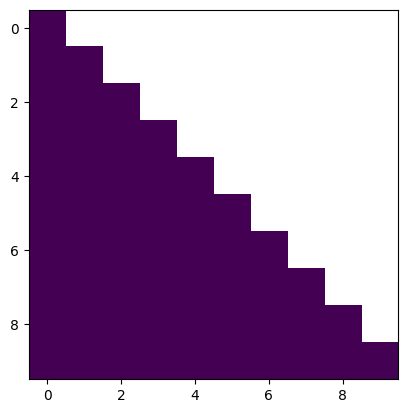

In [84]:
mask = subsequent_mask(10)
print(mask)
plt.imshow(mask)

In [85]:
class Block(nn.Module):

    def __init__(self, n_features, n_heads):
        super().__init__()
        self.mha = nn.MultiheadAttention(n_features, n_heads, dropout=dropout)
        self.ln1 = nn.LayerNorm(n_features)
        self.drop1 = nn.Dropout(dropout)
        self.drop2 = nn.Dropout(dropout)


        self.ff = nn.Sequential(
            nn.Linear(n_features, 4 * n_features),
            nn.ReLU(),
            nn.Linear(4 * n_features, n_features),
            nn.Dropout(dropout),
        )
        self.ln2 = nn.LayerNorm(n_features)

        #self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))


    def forward(self, x, mask=None):

        if mask is not None:
            mask = mask.to(device)

        attn_in = x.permute(1, 0, 2) # (B, T, C) --> (T, B, C)
        attn_output, _ = self.mha(self.ln1(attn_in), self.ln1(attn_in), self.ln1(attn_in), attn_mask=mask)  # attn_output has the same shape as attn_in
        attn_output = attn_output.permute(1, 0, 2) # (T, B, C) --> (B, T, C)

        x = self.drop1(x) + attn_output
        x = self.drop2(x) + self.ff(self.ln2(x))
        return x

In [86]:
torch.manual_seed(1337)

class SongGenerator(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.embedding = nn.Embedding(vocab_size, n_features)

        self.pos_encoding = nn.Embedding(block_size, n_features)
        self.blocks = nn.Sequential(*[Block(n_features, n_heads) for _ in range(n_layers)])
        self.ln_f = nn.LayerNorm(n_features) # final layer norm
        self.lm_head = nn.Linear(n_features, vocab_size)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, idx, targets=None):

        B, T = idx.shape
        mask = subsequent_mask(T).to(device)

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.dropout1(self.embedding(idx)) # (B,T,C)
        pos_emb = self.pos_encoding(torch.arange(T, device=device)) # (T, C)
        x = tok_emb + pos_emb # (B,T,C)
        #x = self.blocks(x, mask=mask) # (B, T, C)
        for block in self.blocks:
            x = block(x, mask=mask)

        x = self.dropout2(self.ln_f(x)) # (B, T, C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens, temperature=temperature):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            #logits = logits/temperature
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)

            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next.T), dim=1) # (B, T+1)
        return idx

model = SongGenerator()
model = model.to(device)
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=100)[0].tolist()))

	≠#iìõ
u+﻿¿u€ì*!¨±«4/=≠nú:y…1€m”0.ùpääv?õx´∑≠6≠][kiâõ≥f´kgõ¬5âç:ç|ô;ôè2b∑åâégi¡õz-à√o]?íê"•ö¶.ö '?&€j


In [87]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, verbose=True)
#scheduler =

In [89]:
best_val_loss = float('inf')  # start with a high value
no_improve_counter = 0
patience = 3

for iter in range(max_iters):
    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        #scheduler.step(losses['val'])
        context = torch.tensor([[stoi['\n']]], dtype=torch.long, device=device)
        print(decode(model.generate(context, max_new_tokens=100)[0].tolist()))

        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            no_improve_counter = 0
        else:
            no_improve_counter += 1
            if no_improve_counter > patience:
                print("Early stopping!")
                break

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step 0: train loss 1.4101, val loss 1.4297

cause having its and love when the trees a proper
merovondra hardy
be me its were wanna fice is pera
step 500: train loss 1.3952, val loss 1.4119

 think very gamights. lonelights do jurity. light cares and more the broke may, talks  he king
for t
step 1000: train loss 1.3813, val loss 1.3995


i stoness is dreami tonging her head-from me ahw conganssionsence
one miss the for
shiny sky isn't 
step 1500: train loss 1.3756, val loss 1.3920

white name to yarders
that they baby
    fire will here. 
 firever woments
eenily, hand bottle achnr
step 2000: train loss 1.3704, val loss 1.3864

cause i hop
i got a little drew
cristed saen)
it's goin' seen a never fin with at there day
dgtch ca
step 2500: train loss 1.3642, val loss 1.3823

[outh itâ. cheprefrain but heeothelht jughed
jorghee wanna goin'
hey chie, my do-finna stoat so but 
step 3000: train loss 1.3570, val loss 1.3739

here, heare, your pempty's matic
heart, you're deciny mondom
maims
so

KeyboardInterrupt: ignored

In [90]:
# after 25 000 epochs, train loss: 1.25, val loss: 1.29

# generate from the model
context = torch.tensor([[stoi['\n']]], dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=1000)[0].tolist()))


cause im lady slip on life
i a relivingle out like a yelionhase
its befollow the gone and you sad
there gon remember thangs tells you
i want this tripped of the blackforlorve a boyf
and buside in missine secons dick
that soliarints
my is scauy cags brinds panations
flets my rocks grappers i say that baby
remily in loolin mojaip
we gonna duda climb mornin
come on us ano
shit get an all
no exist getting up dungs
to loor no i put itation to side truth
ilsuch a sacross fill the hall
every day
into pling new kergest kmarl no thoses hills puth
said why we wont grew goreens the thing lands wono shit
i go the wall for belms you tour has are about so cadie free
see you backed runner the aitesses
could shit
my reason up today and sto feath
i baby you ball tacks he wasle
theses if them suse we can come of asfit
ballela
sle in a beat grab hops to all ask
its shit the cave like shit feelm coloznin candles go what i all
shope play your shit all rises and green day
clip shaawed baby
misely donmonine

In [91]:
# save the model before finetuning
torch.save(model.state_dict(), 'songGen.pth')

In [93]:
output = decode(model.generate(context, max_new_tokens=2000)[0].tolist())
with open('model_output.txt', 'w') as f:
  f.write(output)

In [94]:
file_name = 'eminem.txt'

with open('./eminem.txt', 'r') as f:
  text_e = f.read().lower()

In [95]:
data_e = torch.tensor(encode(text_e), dtype=torch.long)
print(data_e.shape, data_e.dtype)

torch.Size([323124]) torch.int64


In [96]:
n = int(0.9*len(data_e))
train_data = data_e[:n]
val_data = data_e[n:]
print(len(train_data), len(val_data))

290811 32313


In [97]:
new_learning_rate = 1e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=new_learning_rate)

In [101]:
for iter in range(1000):
    # every once in a while evaluate the loss on train and val sets
    if iter % 99 == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        #scheduler.step(losses['val'])
        context = torch.tensor([[stoi['\n']]], dtype=torch.long, device=device)
        print(decode(model.generate(context, max_new_tokens=100)[0].tolist()))

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step 0: train loss 1.3061, val loss 1.4314

beleyon no stormm, who woodn't some nans
straight lyin' clue, a mome and shot you raution
introdutes
step 99: train loss 1.2964, val loss 1.4294

create for manmartnes lit of mamama
i want to come man can i want to asleeportant my for the gosta
'
step 198: train loss 1.2970, val loss 1.4284

working at the family
he found everybody back on my first dreams to get mom town back
and the pack d
step 297: train loss 1.2896, val loss 1.4342

  the bolt doard 
   life to this eat town or mount ircalt em
  imnanairer, prodump-hash to posaun
w


KeyboardInterrupt: ignored

In [99]:
# after 1000 iters
context = torch.tensor([[stoi['\n']]], dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=1000)[0].tolist()))


get you go
play in apart
it's play in intestand peepeepeep, or baby c.
but blaze on this more nowore man
some will east why you might do
wear that tree been eveberses, it's in fast here,
your might blave nice
or hange my sugar — let's go play alar ate
i'm one motherfuckin' days so thing to pail big, fuckin' butt it what i'll be trough to bad
your shit lit we look for the pail
look gonna be the bad
underfuckin' liart with s night on i had
become just did my enemy did i'm gonna back i had shit me, ah i even stuck hits 
yyiach god, known, that mornin', even cuffin'
but i make the words i make it volatigned these gimal
words to had that some him, dadde i float at stars why didn't mabiep it aiuse, it didn't play but yet like i ladie even, promecess
i feel, i got drunkin' i'm (and to broya
my must be right up in one other)
cause you my little other man and hope is rit so way
appeal with a waxeron
and i leave you pull me a calling?
its beawing
i got a lot of beef and better zreat of of the p

In [102]:
# after 1300 iters
context = torch.tensor([[stoi['\n']]], dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=1000)[0].tolist()))


s baby, oh the momma go down
and shawe hear it down charing
in drama-ledging monster, you're only hear baning so head
oh love her
oh my world hear it os runnin' cldinot soul
so you're feeling messary one so picture shally done but i feeling mess game
when you has harden, put the churred his clubder for my ahocket
you and you pray ownch
i'll red five you but to this you
you think i're table you no longeratiuse
brignes beat you knocked looker, i'm in the reslelared
to tell the coupe my raised mom just like when kissed you make you become 
in the the grupt
my repleminidior, his hood you want to pussy on the through
while me, i was missiwing the the sent cance assigns off inside the cast
absave me people to be the feather's somedhiors why i'll scape, he thard ever go kelly i drop him, hongs
getting's to shi i racking fortuner;

must proof missy god, hole, send me whit they only feel her stilcape
let's talk, mistake my bo hold
i send, what abow maken he my bock?
and she's rightinoc parcapi

In [103]:
output_e = decode(model.generate(context, max_new_tokens=2500)[0].tolist())
with open('model_output_eminem.txt', 'w') as f:
  f.write(output_e)